<a href="https://colab.research.google.com/github/snagine/pima-data-proj/blob/main/pima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!pip install boto3
import time
import boto3
import pandas as pd
from io import StringIO


In [60]:
!pip install python-dotenv
from dotenv import load_dotenv
load_dotenv()

True

In [64]:
athena_client = boto3.client('athena',
                             region_name=AWS_REGION,
                             aws_access_key_id=AWS_ACCESS_KEY_ID,
                             aws_secret_access_key=AWS_SECRET_ACCESS_KEY)

In [72]:
dic = {}
def download_and_load_query_results(
    client: boto3.client, query_response: dic) -> pd.DataFrame:
    while True:
        try:
            response = client.get_query_results(
                QueryExecutionId=query_response['QueryExecutionId']
            )
            break
        except Exception as e:
          if 'not yet finished' in str(e):
            time.sleep(0.001)
          else:
            raise
            print(e)
    temp_file_location: str = "athena_query_results.csv"
    s3_client = boto3.client('s3',
                             region_name=AWS_REGION,
                             aws_access_key_id=AWS_ACCESS_KEY_ID,
                             aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
    s3_client.download_file(S3_OUTPUT_BUCKET_NAME, f"{S3_OUTPUT_DIRECTORY}/{query_response['QueryExecutionId']}.csv", temp_file_location)
    print(f"Downloaded results to {temp_file_location}")
    df = pd.read_csv(temp_file_location)
    print(df.head())
    return pd.read_csv(temp_file_location)




In [66]:
response = athena_client.start_query_execution(
    QueryString="SELECT * FROM pima_dataset.pima_indian",
    QueryExecutionContext={
        'Database': SCHEMA_NAME
    },
    ResultConfiguration={
        'OutputLocation': S3_STAGING_DIR,
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3'
        }
    }
)

In [77]:

pima_data = download_and_load_query_results(athena_client, response)

Downloaded results to athena_query_results.csv
   pregnancies  glucose  bloodpressure  skinthickness  insulin   bmi  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   pedigree  age  class  
0     0.627   50      1  
1     0.351   31      0  
2     0.672   32      1  
3     0.167   21      0  
4     2.288   33      1  


In [78]:
pima_data.shape

(768, 9)

In [79]:
pima_data.columns

Index(['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin',
       'bmi', 'pedigree', 'age', 'class'],
      dtype='object')

In [80]:
pima_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pregnancies    768 non-null    int64  
 1   glucose        768 non-null    int64  
 2   bloodpressure  768 non-null    int64  
 3   skinthickness  768 non-null    int64  
 4   insulin        768 non-null    int64  
 5   bmi            768 non-null    float64
 6   pedigree       768 non-null    float64
 7   age            768 non-null    int64  
 8   class          768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [82]:
pima_data.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
bloodpressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
skinthickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
bmi,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
pedigree,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
class,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [83]:
def find_outliers_IQR(df):
  for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    print(f"Lower limit of {col} is {lower_limit}")
    print(f"Upper limit of {col} is {upper_limit}")
    print(df[(df[col] < lower_limit) | (df[col] > upper_limit)])
    print("\fake")


In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

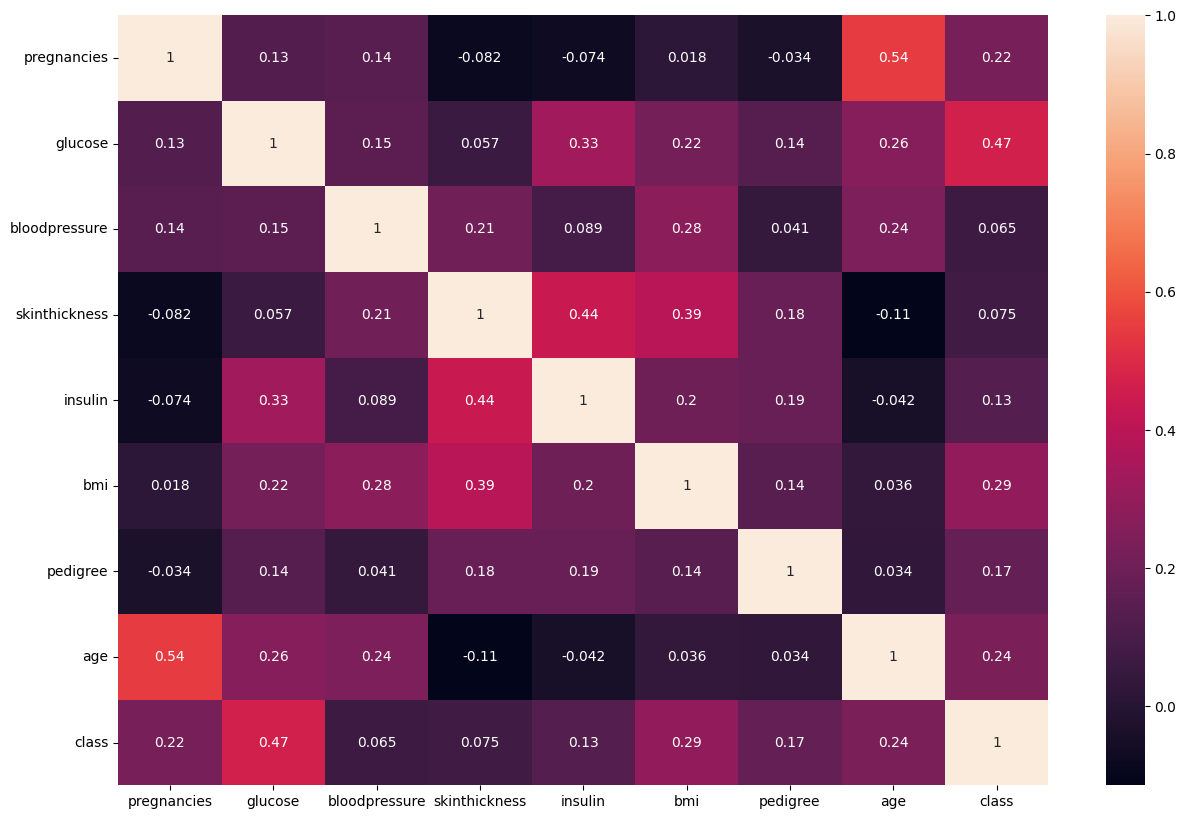

In [86]:
plt.figure(figsize=(15,10))
sns.heatmap(pima_data.corr(), annot=True)
plt.show()

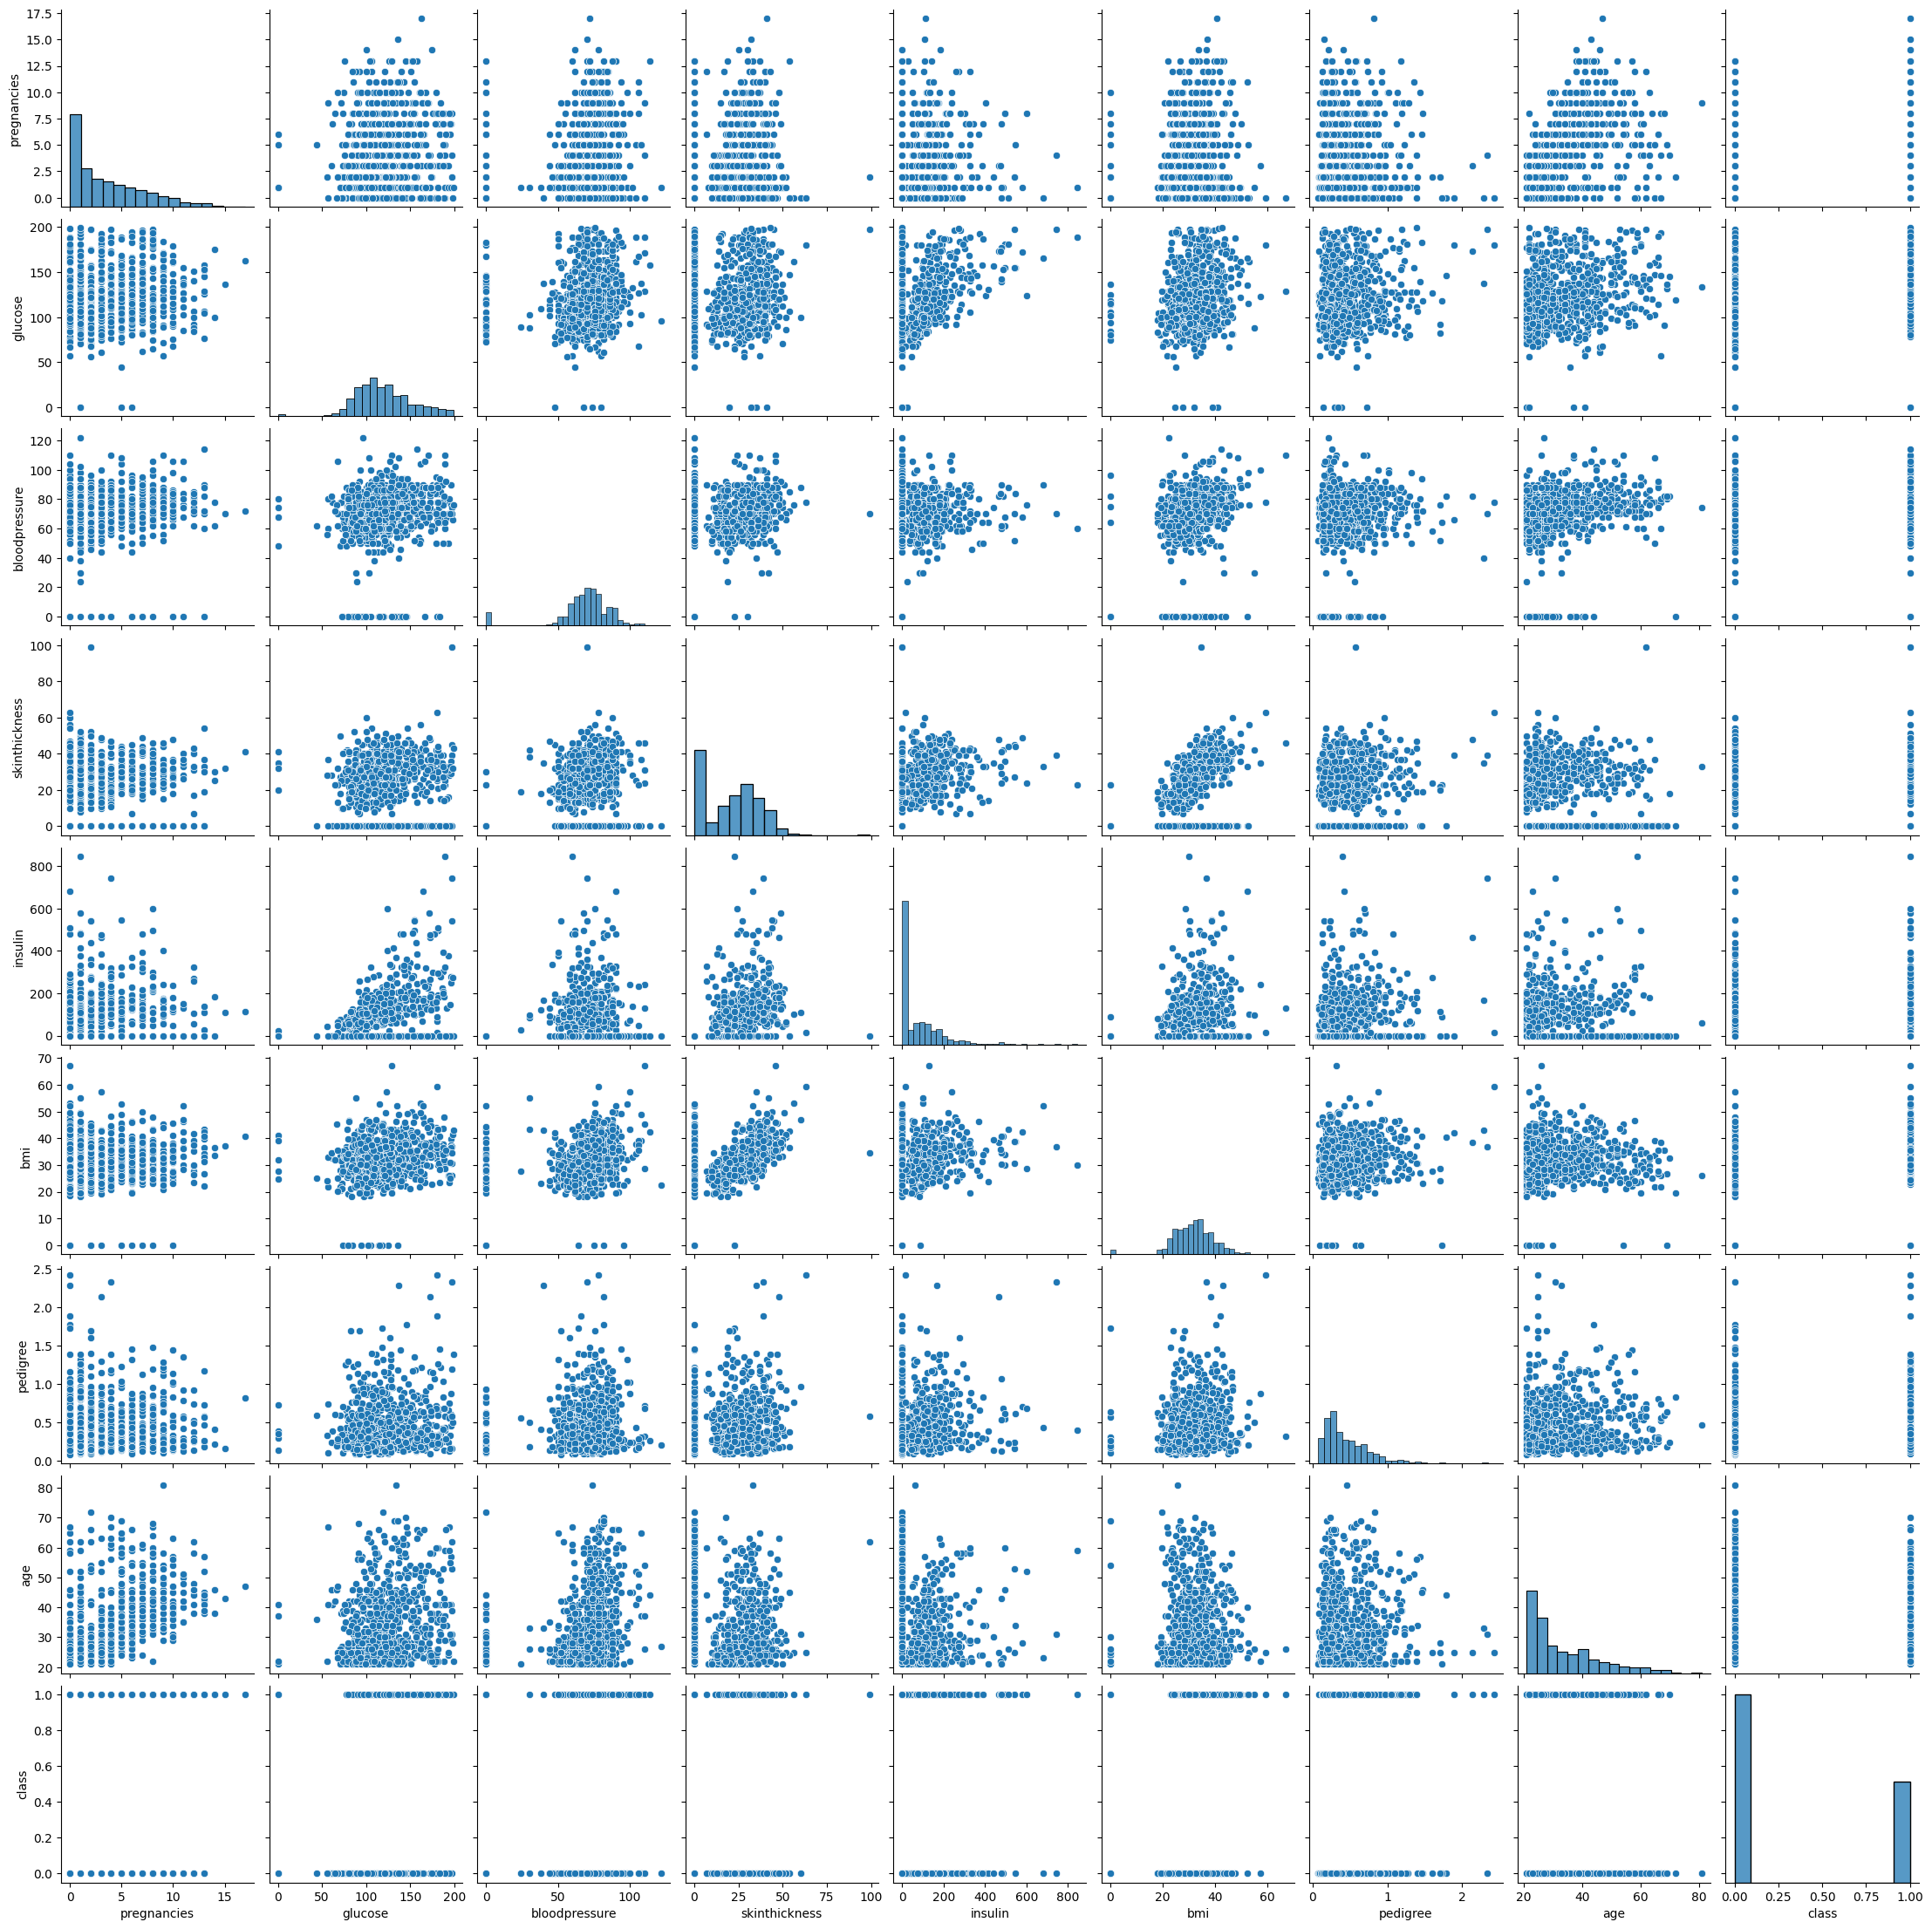

In [88]:
sns.pairplot(pima_data)
plt.show()